In [1]:
import numpy as np
import cv2
from skimage.segmentation import slic
from skimage.future import graph
from skimage import feature, transform
from skimage.feature import local_binary_pattern
from skimage import filters
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline

/home/dzyga/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
def interpolated_shape(mask):
    mask_interp = np.zeros_like(mask)
    contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    true_contour = max(contours, key=cv2.contourArea) 
    epsilon = 0.01*cv2.arcLength(true_contour, True)
    approx = cv2.approxPolyDP(true_contour, epsilon, True)
    return approx

In [3]:
def show_mask(img_gt, mask, approx):
    mask_interp = np.zeros_like(mask)
    cv2.fillPoly(mask_interp, [approx], color=(255,255,255))
    fig, ax = plt.subplots(1,3, figsize = (8,12))
    ax[0].imshow(img_gt)
    ax[0].set_title('Ground truth')
    ax[0].axis('off')
    ax[1].imshow(mask)
    ax[1].set_title('Obtained')
    ax[1].axis('off')
    ax[2].imshow(mask_interp)
    ax[2].set_title('Interpolated')
    ax[2].axis('off');

In [4]:
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }

def merge_boundary(graph, src, dst):
    pass

In [5]:
def floor_label(labels):
    """takes the lable value from the central lower part of image"""
    h, w = labels.shape
    potential_floor = labels[int(h/2):, int(w/4):int(w*3/4)]
    unique, counts = np.unique(potential_floor, return_counts=True)
    res_dict = dict(zip(unique, counts))
    main_label = sorted(res_dict.items(), key=lambda kv: kv[1], reverse=True)[0][0]
    return main_label

In [6]:
def weight_histogram(g_edg, percent_thresh = 0.80):
    """plot histogram of RAG edges weights and return threshold for a given percentile"""
    from scipy.stats import percentileofscore
    w_list = list(g_edg.edges(data='weight'))
    weights = np.asarray([w[2] for w in w_list])
    percentile = np.quantile(weights, percent_thresh)
    return percentile

In [7]:
def masking_image(img, mask):
    dst = img.copy()
    dst[:,:,1] = dst[:,:,1] * mask
    return dst

In [8]:
def show_image(img):
    f = plt.figure(figsize=(8, 12))
    plt.imshow(img)
    plt.axis('off');

In [ ]:
def show_image1(*argv):
    N = len(argv)
    fig, ax = plt.subplots(1, N, figsize = (6, 10))
    for i, arg in enumerate(argv):
        ax[i].imshow(argv[i])
        

In [34]:
def subplots_image(img_dict):  
    """from {'title': image} dictionary create a subplots
    Ex.: show_image('rgb' = img, 'hsv' = hsvimg, 'mask'= mask)  """
    N = len(img_dict)
    fig, ax = plt.subplots(1, N, figsize = (6, 10))
    i = 0
    for text, image in img_dict.items(): 
        ax[i].imshow(image)
        ax[i].set_title(text)
        ax[i].axis('off');
        i+=1
    plt.show()

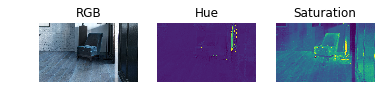

In [35]:
img_dict = {'RGB':img, 'Hue':himg, 'Saturation':simg}
subplots_image(img_dict)

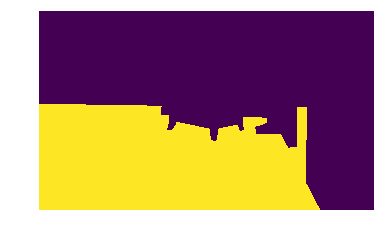

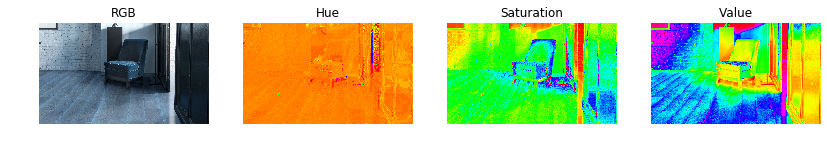

In [9]:
fname = '50917092_2014590568590932_4249364050510610432_o.jpg'
file = './dataset/' + fname 
file_gt = './dataset/ground_truth/' + fname

img = cv2.imread(file)
img_original = img.copy()

imh, imw, imc = img.shape
imh_orig = imh
imw_orig = imw
if imh > 600 and imh < 1000: 
    img = cv2.resize(img, None, fx=0.5,fy=0.5)
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
elif imh > 1000:
    img = cv2.resize(img, None, fx=0.25,fy=0.25)
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
    
img_gt = cv2.imread(file_gt)
img_gt = img_gt[:,:,0]
img_gt[img_gt <= 125] = 0
img_gt[img_gt > 125] = 1

hsvimg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
himg = hsvimg[:,:,0]
simg = hsvimg[:,:,1]
vimg = hsvimg[:,:,2]
# rgbhsvimg = cv2.merge((img, hsvimg))

plt.figure(), plt.imshow(img_gt), plt.axis('off');

fig, axes = plt.subplots(ncols=4, figsize=(14, 2))
axes[0].imshow(img)
axes[0].set_title('RGB')
axes[0].axis('off')
axes[1].imshow(hsvimg[:,:,0],  cmap='hsv')
axes[1].set_title('Hue')
axes[1].axis('off')
axes[2].imshow(hsvimg[:,:,1],  cmap='hsv')
axes[2].set_title('Saturation');
axes[2].axis('off')
axes[3].imshow(hsvimg[:,:,2],  cmap='hsv')
axes[3].set_title('Value')
axes[3].axis('off');

In [10]:
num_segmnts = 300
labels = slic(hsvimg, n_segments = num_segmnts, sigma = 5, compactness = 1)

In [11]:
METHOD = 'var' # NaN appears
radius = 5
n_points = 8 * radius
lbp = local_binary_pattern(simg, n_points, radius, METHOD)

# Handle missing value
lbp[np.isnan(lbp)] = np.nanmean(lbp)

lbp2 = local_binary_pattern(simg, n_points, radius, METHOD)
lbp3 = local_binary_pattern(vimg, n_points, radius, METHOD)
lbp = lbp3+lbp2
x = 5
lbp[:, :x] = np.median(lbp)
lbp[:x, :] = np.median(lbp)
lbp[-x:, :] = np.median(lbp)
lbp[:, -x:] = np.median(lbp)

/home/dzyga/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [12]:
edges = filters.sobel(cv2.blur(simg,(5,5)))
g_edg = graph.rag_boundary(labels, edges, connectivity=2)

0.052079363521264084


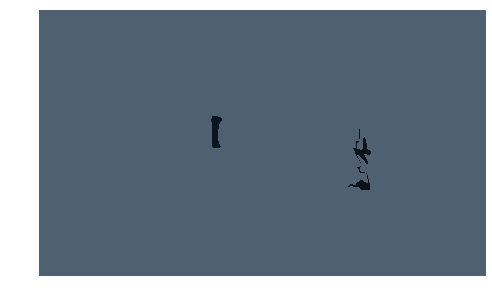

In [13]:
Q = weight_histogram(g_edg, percent_thresh = 0.95)
print(Q)
labels_hier_slic = graph.merge_hierarchical(labels, g_edg, Q, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

hierarchical_slic = color.label2rgb(labels_hier_slic, img, kind='avg')
show_image(hierarchical_slic)

target_label = floor_label(labels_hier_slic)
mask = np.zeros(labels_hier_slic.shape)
mask[labels_hier_slic == target_label] = 1

# reshape mask
if mask.shape[0] != imh_orig:
    mask = cv2.resize(mask, (imw_orig, imh_orig))
    mask[mask <= 0.5] = 0
    mask[mask > 0.5] = 1
# show_image(mask)

In [33]:
approx = interpolated_shape(mask)   
print(len(approx))

cv2.fillPoly(mask_interp, [approx], color=(255,255,255))

fig, ax = plt.subplots(1,3, figsize = (8,12))
ax[0].imshow(img_gt)
ax[0].set_title('Ground truth')
ax[0].axis('off')
ax[1].imshow(mask)
ax[1].set_title('Obtained')
ax[1].axis('off')
ax[2].imshow(mask_interp)
ax[2].set_title('Interpolated')
ax[2].axis('off');

4


NameError: name 'mask_interp' is not defined

In [ ]:
# from numpy import random
# contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
# print(len(contours))
# for cnt in contours: 
#     print('Area is ', cv2.contourArea(cnt))
#     print('Perimiter is ', cv2.arcLength(cnt,True))      
#     cv2.drawContours(mask_interp, cnt, -1, random.rand(3), 3)
# show_image(mask_interp)

# show_image(mask_interp)
    
# Max contour
# areas = []
# for cnt in contours:
#     areas.append(cv2.contourArea(cnt))    
# true_contour = contours[np.argmax(areas)]
# cv2.drawContours(mask_interp, true_contour, -1, random.rand(3), 3)

### Line detector 

In [ ]:
import math
tmp = edges.copy()
tmp[tmp<tmp.max()/2]=0
tmp[tmp>=tmp.max()/2]=255
dst = cv2.Canny(cv2.convertScaleAbs(mask_interp), 50, 200, None, 3)

In [ ]:
fld = cv2.ximgproc.createFastLineDetector()

#Detect lines in the image
lines = fld.detect(dst)
cdst = img.copy()
for line in lines: 
    cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
show_image(cdst)

### Hough lines

In [ ]:
lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
cdst = img.copy()
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
show_image(cdst)

In [ ]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 250  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(dst, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
line_image = img.copy()
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
show_image(line_image)

In [ ]:
# height,width = mask.shape
# skel = np.zeros([height,width],dtype=np.uint8)      #[height,width,3]
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
# temp_nonzero = np.count_nonzero(mask)
# while(np.count_nonzero(mask) != 0 ):
#     eroded = cv2.erode(mask,kernel)
# #     cv2.imshow("eroded",eroded)   
#     temp = cv2.dilate(eroded,kernel)
# #     cv2.imshow("dilate",temp)
#     temp = cv2.subtract(mask,temp)
#     skel = cv2.bitwise_or(skel,temp)
#     mask = eroded.copy()


In [ ]:
show_image(img)

In [ ]:
def thresh_itterate(labels, g_edg):
    for p in np.linspace(0.60, 0.95, 7):
        Q = weight_histogram(g_edg, percent_thresh = p)
        print('Percentile of a score {} is {}'.format(p, Q))
        labels_hier_slic = graph.merge_hierarchical(labels, g_edg, Q, rag_copy=True,
                                           in_place_merge=True,
                                           merge_func=merge_boundary,
                                           weight_func=weight_boundary)
        target_label = floor_label(labels_hier_slic)
        mask = np.zeros(labels_hier_slic.shape)
        mask[labels_hier_slic == target_label] = 1
        approx = interpolated_shape(mask)
#         show_mask(img_gt, mask, approx)
        print(len(approx))
        if len(approx)<15:
              break
    return approx
